In [1362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [1363]:
# reading the dataset
aus_propdata = pd.read_csv("train.csv")
aus_propdata.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1364]:
len(aus_propdata.columns.tolist())

81

### Data Exploration

In [1365]:
#summary of the data
print(aus_propdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### We may not conclude anything really if we just take years and months, we derive the property age and remodelling age too which may become good predictors in our analysis.

In [1366]:
#Addition of two more predictors can be done:
from datetime import datetime as dt
'''
* Property age in months: prop_age
* Actual age of property after remodelling: remod_age
['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']
'''
dt_sold = pd.to_datetime(aus_propdata.YrSold.astype(str) + '/' + aus_propdata.MoSold.astype(str) + '/01')
dt_curr = pd.to_datetime(pd.Timestamp("today").strftime("%Y-%m-%d"))
diff_in_months = (dt_curr - dt_sold)/np.timedelta64(1, 'M')

aus_propdata['prop_age_mos'] = diff_in_months.astype(int)
aus_propdata['remod_age_yrs'] = (aus_propdata['YearRemodAdd'] - aus_propdata['YearBuilt']).astype(int)

### Even we can see that the GarageBuilt had some missing values down, we can fill them with 0s as we figured out these houses do not have garages, so we will take them as 0 only and can derive the Garage age the same way we figured out the property age.

In [1367]:
#Fillinf the NaN was required as the LinearRegres
aus_propdata['GarageYrBlt'].isnull().sum()
aus_propdata['GarageYrBlt'] = aus_propdata['GarageYrBlt'].fillna(0)
aus_propdata['GarageYrBlt'] = aus_propdata['GarageYrBlt'].astype(int)
curr_yr = 2022

garage_age_yrs = []
for yr in aus_propdata['GarageYrBlt']:
    if yr != 0:
        garage_age_yrs.append(curr_yr - yr)
    else:
        garage_age_yrs.append(0)

aus_propdata['garage_age_yrs'] = (pd.Series(garage_age_yrs)).astype(int)
aus_propdata['garage_age_yrs']

0        19
1        46
2        21
3        24
4        22
5        29
6        18
7        49
8        91
9        83
10       57
11       17
12       60
13       16
14       62
15       31
16       52
17       55
18       18
19       64
20       17
21       92
22       20
23       46
24       54
25       15
26       17
27       14
28       65
29      102
30      102
31       56
32       15
33       63
34       17
35       18
36       27
37       68
38       69
39        0
40       57
41       63
42       39
43       45
44       63
45       17
46       19
47       16
48        0
49       56
50       25
51       37
52       59
53       41
54       60
55       58
56       23
57       18
58       16
59       49
60       16
61       87
62       16
63       32
64       24
65       18
66       52
67       19
68       77
69       69
70       49
71       35
72       24
73       33
74      107
75       49
76       66
77       74
78        0
79       56
80       54
81       24
82       15
83  

In [1368]:
#summary of the data
print(aus_propdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 84 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              1460 non-null   int64  
 1   MSSubClass      1460 non-null   int64  
 2   MSZoning        1460 non-null   object 
 3   LotFrontage     1201 non-null   float64
 4   LotArea         1460 non-null   int64  
 5   Street          1460 non-null   object 
 6   Alley           91 non-null     object 
 7   LotShape        1460 non-null   object 
 8   LandContour     1460 non-null   object 
 9   Utilities       1460 non-null   object 
 10  LotConfig       1460 non-null   object 
 11  LandSlope       1460 non-null   object 
 12  Neighborhood    1460 non-null   object 
 13  Condition1      1460 non-null   object 
 14  Condition2      1460 non-null   object 
 15  BldgType        1460 non-null   object 
 16  HouseStyle      1460 non-null   object 
 17  OverallQual     1460 non-null   i

In [1369]:
# all numeric (float and int) variables in the dataset
aus_propdata_numeric = aus_propdata.select_dtypes(include=['float64', 'int64'])
aus_propdata_numeric.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,prop_age_mos,remod_age_yrs,garage_age_yrs
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003,2,548,0,61,0,0,0,0,0,2,2008,208500,168,0,19
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976,2,460,298,0,0,0,0,0,0,5,2007,181500,177,0,46
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001,2,608,0,42,0,0,0,0,0,9,2008,223500,161,1,21
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998,3,642,0,35,272,0,0,0,0,2,2006,140000,192,55,24
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000,3,836,192,84,0,0,0,0,0,12,2008,250000,158,0,22


In [1370]:
aus_propdata_numeric_list = aus_propdata_numeric.columns.tolist()
aus_propdata_numeric_list

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'prop_age_mos',
 'remod_age_yrs',
 'garage_age_yrs']

Attributes Analysis

In [1371]:
#But there can be columns which seems numeric but are categories
#Target variable needs to be different as well
target_var = ['SalePrice']

#Variables which seems numeric but are categories unordered
predictor_num_cat_unordered = ['MSSubClass', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'BedroomAbvGr',
                               'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

#Variables which seems numeric but are categories ordered
predictor_num_cat_ordered = ['OverallQual','OverallCond']

#Variables which are months, year which may not needed as we have derived variables
predictor_yr_month = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

#Unite all kinds of lists
concatenate_lists = target_var + predictor_num_cat_unordered + predictor_num_cat_ordered + predictor_yr_month
concatenate_lists

#Predictor_pure_numeric
predictor_pure_numeric = list(set(aus_propdata_numeric).difference(concatenate_lists))

#Predictor_pure_categorical
predictor_pure_cat = list(set(aus_propdata.columns.tolist()).difference(aus_propdata_numeric.columns.tolist()))

Here, although some predictors are numeric (int), we'd rather treat it as categorical since it has few discrete values.

In [1372]:
#Check the category values for predictors which appear as numeric but could be categories
predictor_num_cat_list = [predictor_num_cat_unordered,predictor_num_cat_ordered]
for lst in predictor_num_cat_list:
    for predictor in lst:
        print(predictor,'\n', aus_propdata[predictor].astype('category').value_counts())

MSSubClass 
 20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
BsmtFullBath 
 0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64
BsmtHalfBath 
 0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64
FullBath 
 2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64
BedroomAbvGr 
 3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64
KitchenAbvGr 
 1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64
TotRmsAbvGrd 
 6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: TotRmsAbvGrd, dtype: int64
Fireplaces 
 0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64
GarageCars 
 2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64
OverallQ

In [1373]:
# dropping the list of predictors which could be categories
for lst in predictor_num_cat_list:
    aus_propdata_numeric = aus_propdata_numeric.drop(lst, axis=1)

#Also drop 'id' as it is not needed
aus_propdata_numeric = aus_propdata_numeric.drop(['Id'], axis=1)

aus_propdata_numeric.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,HalfBath,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,prop_age_mos,remod_age_yrs,garage_age_yrs
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,2003,548,0,61,0,0,0,0,0,2,2008,208500,168,0,19
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1976,460,298,0,0,0,0,0,0,5,2007,181500,177,0,46
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,2001,608,0,42,0,0,0,0,0,9,2008,223500,161,1,21
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,756,0,1717,0,1998,642,0,35,272,0,0,0,0,2,2006,140000,192,55,24
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,2000,836,192,84,0,0,0,0,0,12,2008,250000,158,0,22


A scatter plot could have been used to check the correlation but too many variables, hence heatmap can help us

In [1374]:
#Plot the scatter plot, visualise the data for the numericals
#sns.pairplot(aus_propdata[aus_propdata_numeric.columns.tolist()])


In [1375]:
# correlation matrix
cor = aus_propdata_numeric.corr()
cor

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,HalfBath,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,prop_age_mos,remod_age_yrs,garage_age_yrs
LotFrontage,1.000000,0.426095,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.053532,0.105237,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799,-0.009455,-0.079480,-0.023480
LotArea,0.426095,1.000000,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.014259,0.072599,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843,0.014205,-0.005926,0.051291
YearBuilt,0.123349,0.014228,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.242656,0.272029,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897,0.011635,-0.733896,-0.632331
YearRemodAdd,0.088866,0.013788,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.183331,0.146357,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101,-0.039802,0.111922,-0.527265
MasVnrArea,0.193458,0.104160,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.201444,0.133766,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493,0.009307,-0.237414,-0.184420
BsmtFinSF1,0.233633,0.214103,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.004262,0.115843,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420,-0.011814,-0.199531,-0.097431
BsmtFinSF2,0.049900,0.111170,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,-0.032148,0.035070,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378,-0.029431,0.003443,0.095702
BsmtUnfSF,0.132644,-0.002618,0.149040,0.181133,0.114442,-0.495251,-0.209294,1.000000,0.415360,0.317987,0.004469,0.028167,0.240257,-0.041118,0.042720,0.183303,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479,0.035710,-0.031127,-0.159258
TotalBsmtSF,0.392075,0.260833,0.391452,0.291066,0.363936,0.522396,0.104810,0.415360,1.000000,0.819530,-0.174512,-0.033245,0.454868,-0.048804,0.176359,0.486665,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581,0.012864,-0.237527,-0.226508
1stFlrSF,0.457181,0.299475,0.281986,0.240379,0.344501,0.445863,0.097117,0.317987,0.819530,1.000000,-0.202646,-0.014241,0.566024,-0.119916,0.166642,0.489782,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,-0.021096,0.031372,-0.013604,0.605852,0.008369,-0.145203,-0.150410


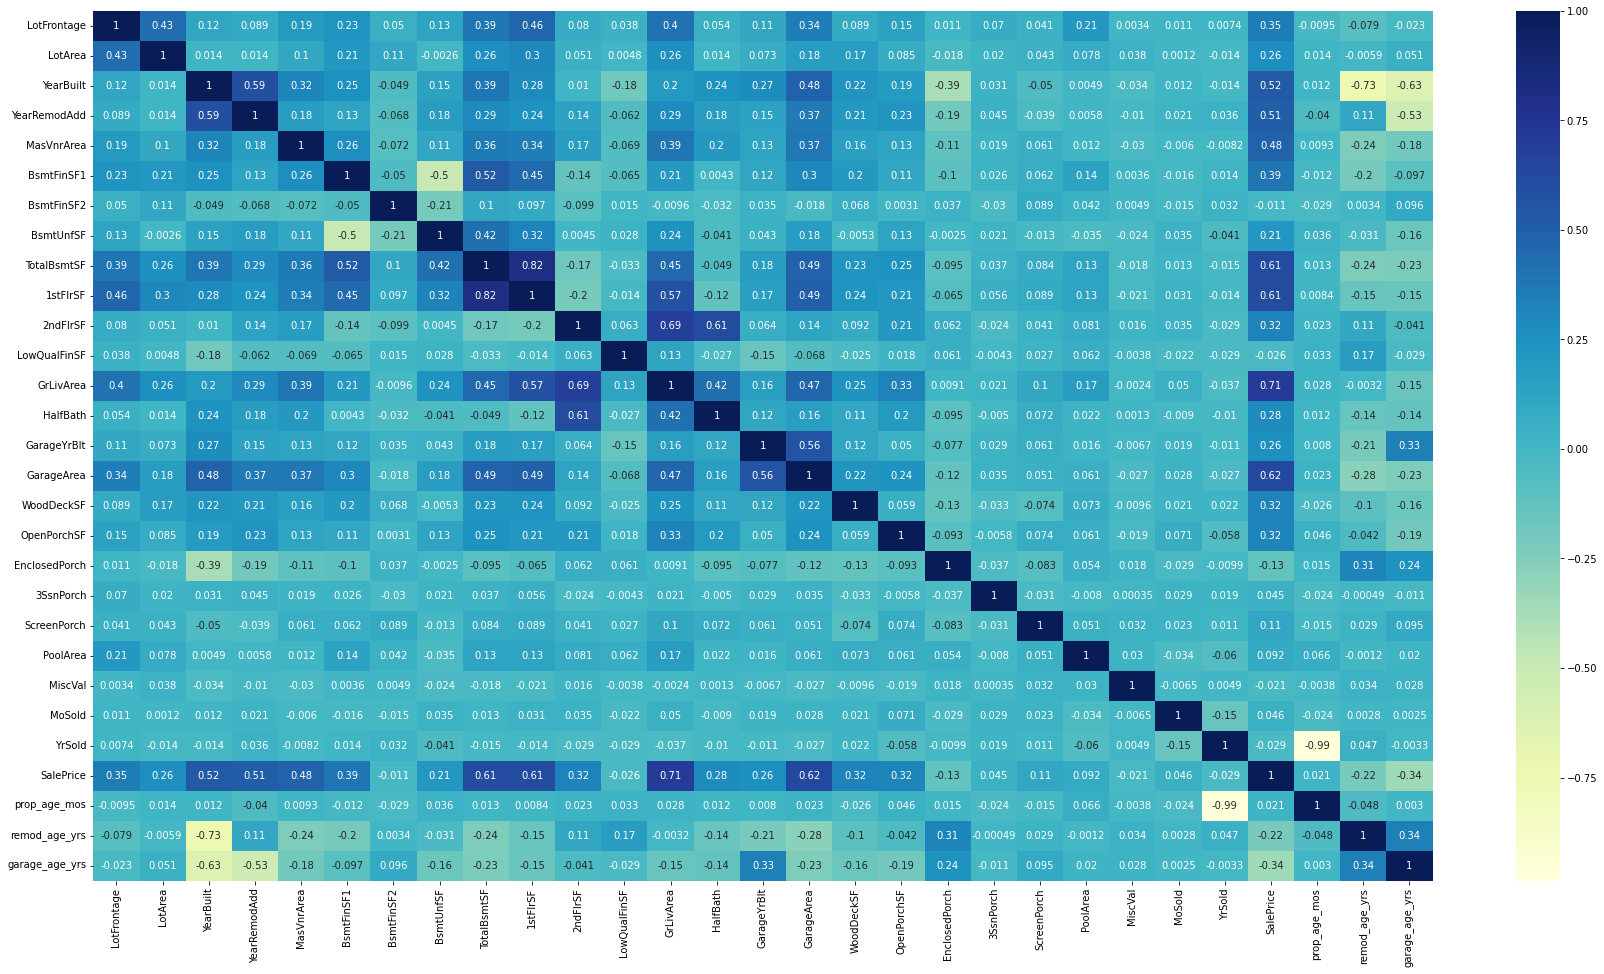

In [1376]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(30,16))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

We can conclude few stuffs from the above heatmap:
* Salesprice which is our traget var is highly dependent upon:
    * GrLivArea: Above ground living area square feet
    * Garage area
    * TotalBsmtSF: Total square feet of basement area
    * 1stFlrSF: First Floor square feet
    * Year Built
    * Remodel date which can be the construction date/year built if not remodelled.
    
* Speaking about correlations among predictors:
    * Year built and garage year built have correlations among them which suggests that they might be built together.
    * Same with garage built year and year of remodel.
    * year of remodel and year built.
    * Unfinished square feet of basement area with Type 2 finished square feet inversely. (negative correlation)
    * Total square feet of basement area with Type 2 finished square feet and 1st floor square feet.
    

In [1377]:
#Merge it into one
predictor_cat = predictor_num_cat_unordered + predictor_num_cat_ordered + predictor_pure_cat
#predictor_cat

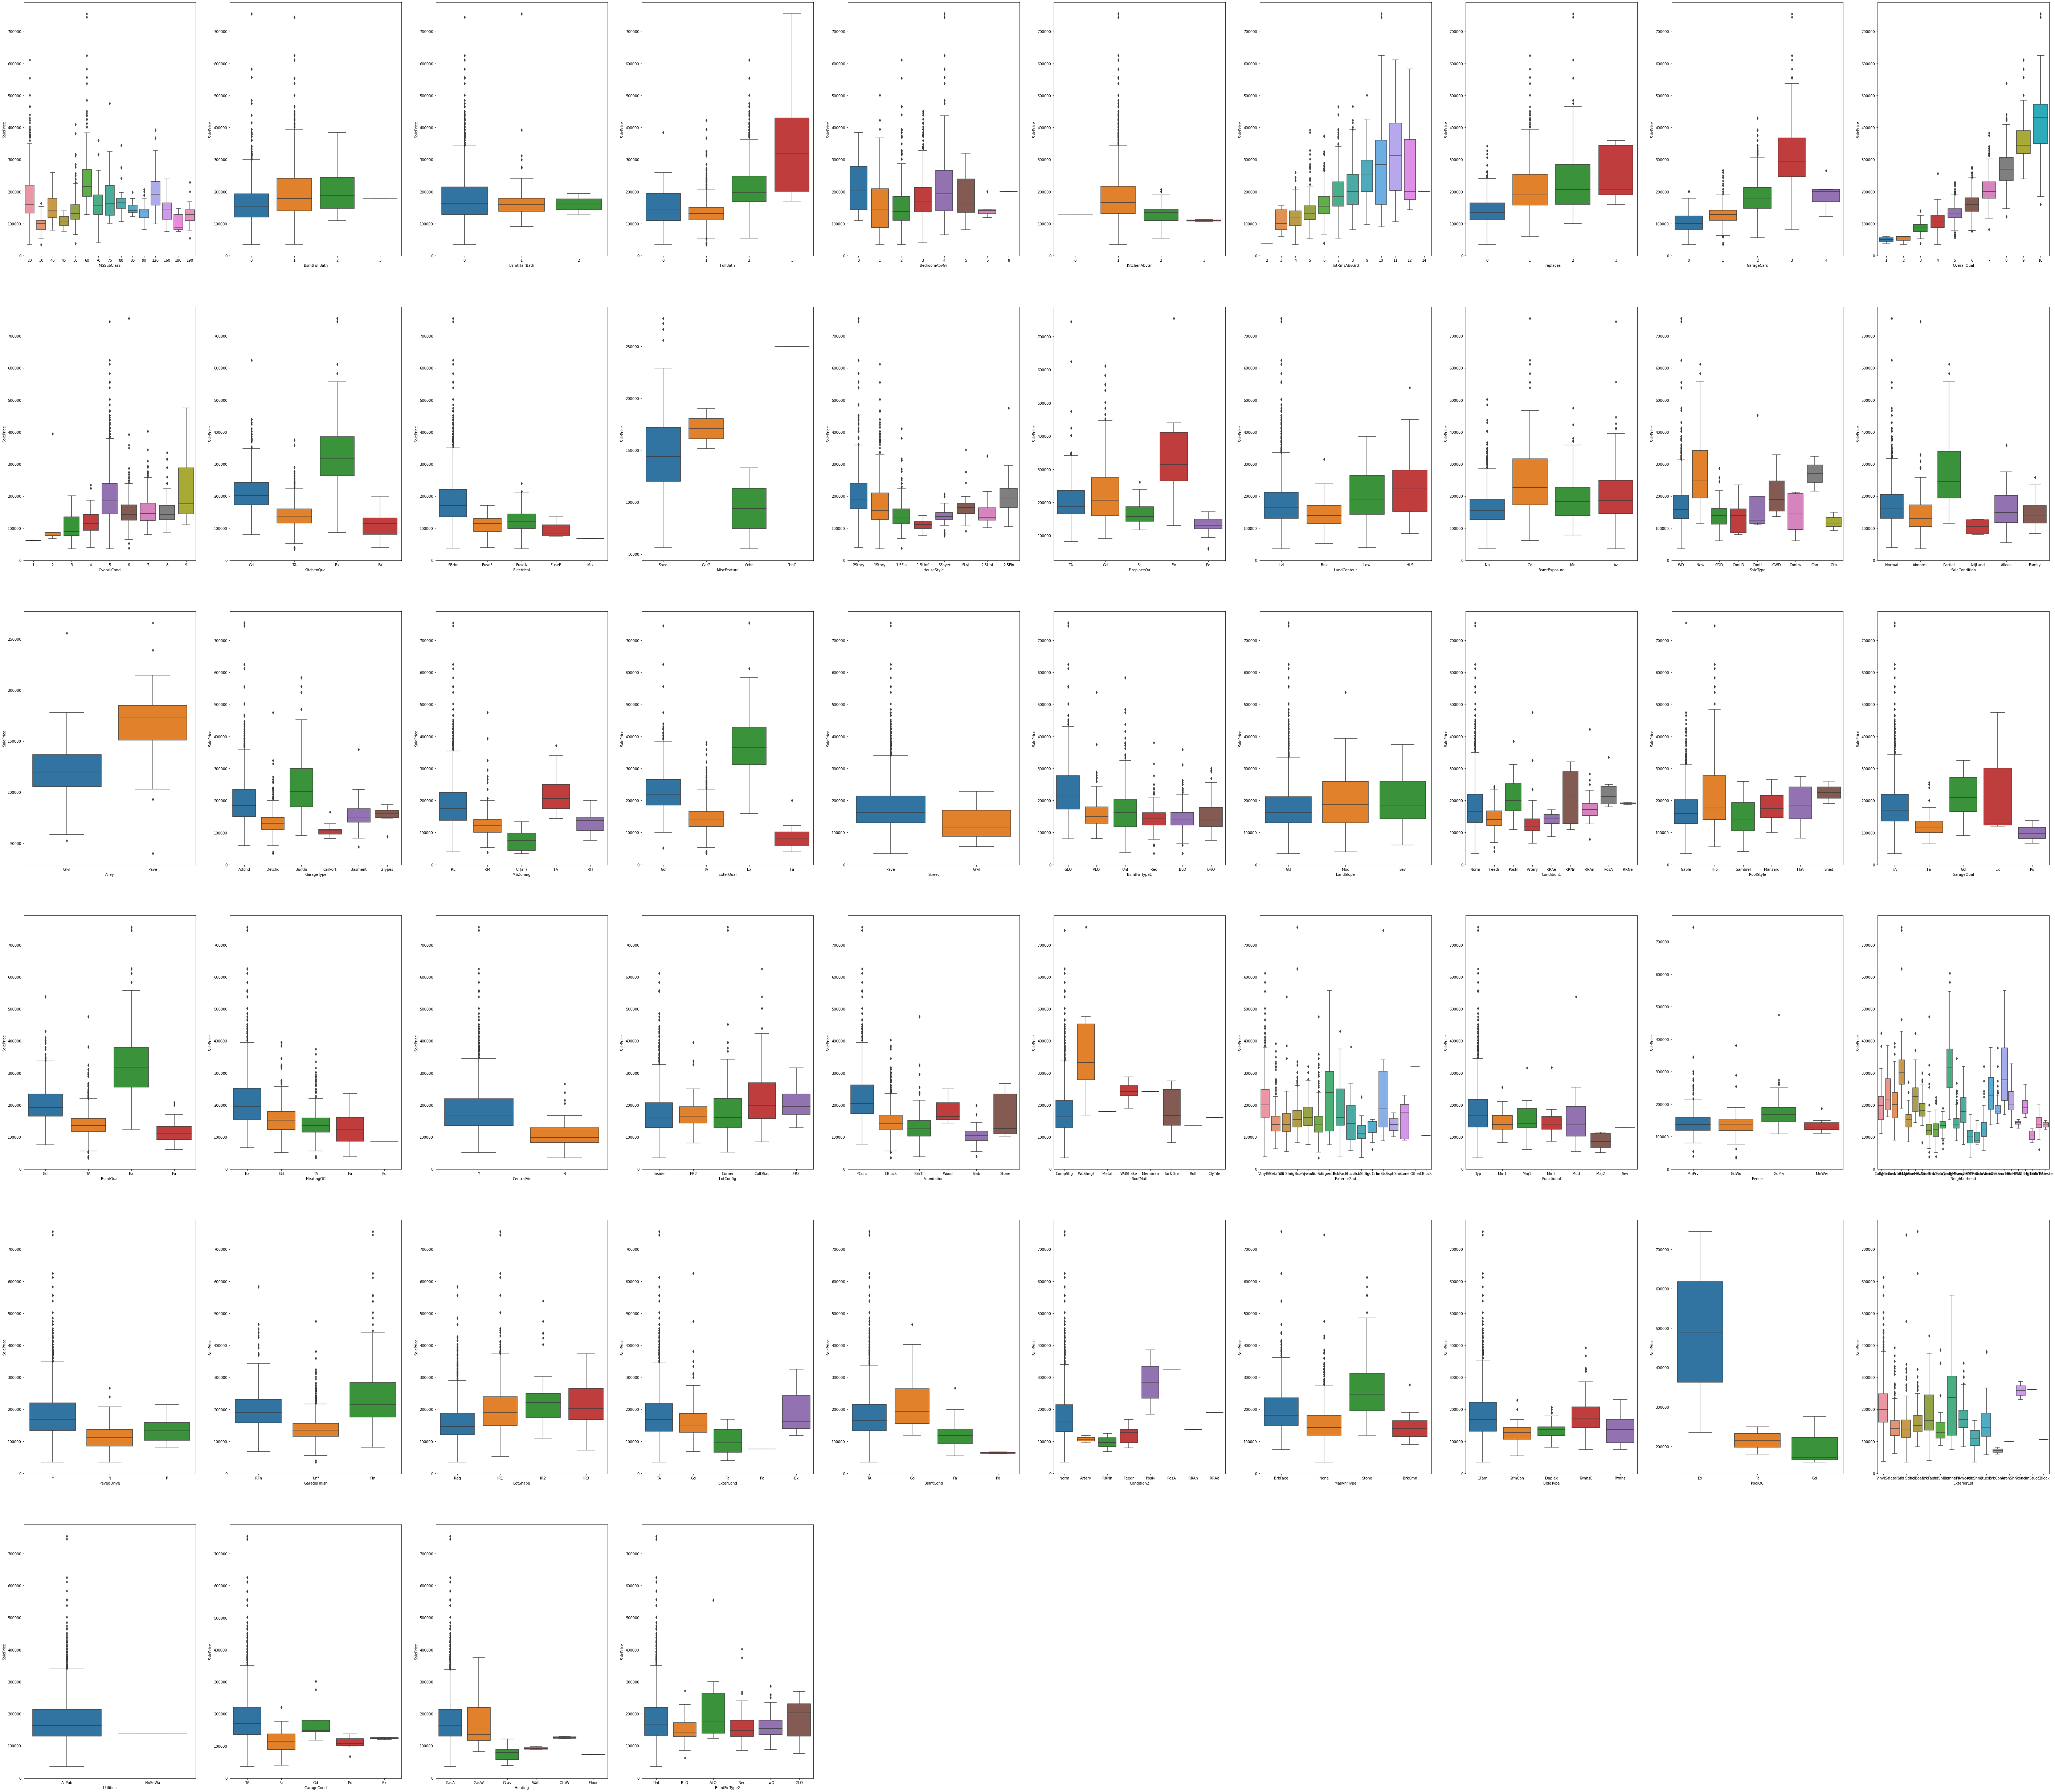

In [1378]:
#For the categories we will be using bar plot
plt.figure(figsize=(100, 90))
count = 0
for i in range (1,len(predictor_cat) + 1):
    plt.subplot(6,10,i)
    sns.boxplot(x = predictor_cat[i-1], y = 'SalePrice', data = aus_propdata)
count = i

So with the above bar plots of the categorical data with the target variable, we can conclude something like below:
* Sales price more or less increases with basement with full bathrooms.
* With increasing overall quality the sales price do increase.
* With good basement exposure, we can see the sales price go up.
* Heating quality do increase the sale price of the house.

### Data Cleaning

In [1379]:
#Check for the missing values in the numerical predictors
for predictor in predictor_pure_numeric:
    if aus_propdata[predictor].isnull().sum() > 0:
        print (predictor, ':', aus_propdata[predictor].isnull().sum())
#As we see we have two predictors where there are missing values

LotFrontage : 259
MasVnrArea : 8


In [1380]:
#Check for the missing values in the predictors which appear numerical but can be categories
for lst in predictor_num_cat_list:
    for predictor in lst:
        print (predictor, ':', aus_propdata[predictor].isnull().sum())
        aus_propdata[predictor] = aus_propdata[predictor].astype('object')
#No missing values in the predictors which are numerical but are categories.

MSSubClass : 0
BsmtFullBath : 0
BsmtHalfBath : 0
FullBath : 0
BedroomAbvGr : 0
KitchenAbvGr : 0
TotRmsAbvGrd : 0
Fireplaces : 0
GarageCars : 0
OverallQual : 0
OverallCond : 0


In [1381]:
#Check the NANs in the categorical columns
for predictor in predictor_pure_cat:
    if aus_propdata[predictor].isnull().sum() > 0:
        print (predictor, ':', aus_propdata[predictor].isnull().sum())
        #Replace the NA values with the string "not present" as they mean that the feature is not present.
        aus_propdata[predictor] = aus_propdata[predictor].fillna('Not present')
        print (predictor, ':', aus_propdata[predictor].isnull().sum())

Electrical : 1
Electrical : 0
MiscFeature : 1406
MiscFeature : 0
FireplaceQu : 690
FireplaceQu : 0
BsmtExposure : 38
BsmtExposure : 0
Alley : 1369
Alley : 0
GarageType : 81
GarageType : 0
BsmtFinType1 : 37
BsmtFinType1 : 0
GarageQual : 81
GarageQual : 0
BsmtQual : 37
BsmtQual : 0
Fence : 1179
Fence : 0
GarageFinish : 81
GarageFinish : 0
BsmtCond : 37
BsmtCond : 0
MasVnrType : 8
MasVnrType : 0
PoolQC : 1453
PoolQC : 0
GarageCond : 81
GarageCond : 0
BsmtFinType2 : 38
BsmtFinType2 : 0


In [1382]:
#We have some values in GarageYrBuilt was have NaNs which may also mean the garage is not there.
for predictor in predictor_yr_month:
    if aus_propdata[predictor].isnull().sum() > 0:
        print (predictor, ':', aus_propdata[predictor].isnull().sum())
#The Garage type, Garage quality and Garage FInish above can help here, as the count is 81, there is no garage.

In [1383]:
#Check the data once again
aus_propdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 84 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              1460 non-null   int64  
 1   MSSubClass      1460 non-null   object 
 2   MSZoning        1460 non-null   object 
 3   LotFrontage     1201 non-null   float64
 4   LotArea         1460 non-null   int64  
 5   Street          1460 non-null   object 
 6   Alley           1460 non-null   object 
 7   LotShape        1460 non-null   object 
 8   LandContour     1460 non-null   object 
 9   Utilities       1460 non-null   object 
 10  LotConfig       1460 non-null   object 
 11  LandSlope       1460 non-null   object 
 12  Neighborhood    1460 non-null   object 
 13  Condition1      1460 non-null   object 
 14  Condition2      1460 non-null   object 
 15  BldgType        1460 non-null   object 
 16  HouseStyle      1460 non-null   object 
 17  OverallQual     1460 non-null   o

### Filling the missing values

In [1384]:
#We had some missing values in the numeric data, as both are related to the distance, we can safely use median here
#to impute in the missing values.
#As the data missing is pretty low as compared to the amount of rows we have per column, we can safely impute.

for predictor in predictor_pure_numeric:
    if aus_propdata[predictor].isnull().sum() > 0:
        print(predictor, ':', aus_propdata[predictor].median())
        aus_propdata[predictor] = aus_propdata[predictor].fillna(aus_propdata[predictor].median())

LotFrontage : 69.0
MasVnrArea : 0.0


### Check the outliers: Either use the 3 sigma rule or IQR only for numerical data

In [1385]:
for col_name in predictor_pure_numeric:
    print(aus_propdata[col_name])

0        150
1        284
2        434
3        540
4        490
5         64
6        317
7        216
8        952
9        140
10       134
11       177
12       175
13      1494
14       520
15       832
16       426
17         0
18       468
19       525
20      1158
21       637
22      1777
23       200
24       204
25      1566
26       180
27       486
28       207
29       520
30       649
31      1228
32      1234
33       380
34       408
35      1117
36      1097
37        84
38       326
39         0
40       445
41       383
42         0
43       167
44       465
45      1296
46        83
47      1632
48       736
49       192
50       612
51       816
52         0
53        32
54         0
55       935
56       321
57       860
58      1410
59       148
60       217
61       530
62      1346
63       576
64       318
65      1143
66      1035
67       440
68       747
69       701
70       343
71       280
72       832
73       404
74       840
75         0
76       724

0        196.0
1          0.0
2        162.0
3          0.0
4        350.0
5          0.0
6        186.0
7        240.0
8          0.0
9          0.0
10         0.0
11       286.0
12         0.0
13       306.0
14       212.0
15         0.0
16       180.0
17         0.0
18         0.0
19         0.0
20       380.0
21         0.0
22       281.0
23         0.0
24         0.0
25       640.0
26         0.0
27       200.0
28         0.0
29         0.0
30         0.0
31         0.0
32         0.0
33         0.0
34       246.0
35       132.0
36         0.0
37       650.0
38         0.0
39         0.0
40       101.0
41         0.0
42         0.0
43         0.0
44         0.0
45       412.0
46         0.0
47         0.0
48         0.0
49         0.0
50         0.0
51         0.0
52         0.0
53         0.0
54         0.0
55       272.0
56       456.0
57         0.0
58      1031.0
59         0.0
60         0.0
61         0.0
62       178.0
63         0.0
64       573.0
65       344.0
66       2

Name: PoolArea, dtype: int64
0        19
1        46
2        21
3        24
4        22
5        29
6        18
7        49
8        91
9        83
10       57
11       17
12       60
13       16
14       62
15       31
16       52
17       55
18       18
19       64
20       17
21       92
22       20
23       46
24       54
25       15
26       17
27       14
28       65
29      102
30      102
31       56
32       15
33       63
34       17
35       18
36       27
37       68
38       69
39        0
40       57
41       63
42       39
43       45
44       63
45       17
46       19
47       16
48        0
49       56
50       25
51       37
52       59
53       41
54       60
55       58
56       23
57       18
58       16
59       49
60       16
61       87
62       16
63       32
64       24
65       18
66       52
67       19
68       77
69       69
70       49
71       35
72       24
73       33
74      107
75       49
76       66
77       74
78        0
79       56
80       54

Name: 3SsnPorch, dtype: int64
0        61
1         0
2        42
3        35
4        84
5        30
6        57
7       204
8         0
9         4
10        0
11       21
12        0
13       33
14      213
15      112
16        0
17        0
18      102
19        0
20      154
21        0
22      159
23      110
24       90
25       56
26       32
27       50
28      258
29        0
30       54
31       65
32       30
33       38
34       47
35       32
36       64
37        0
38       52
39        0
40      138
41      104
42        0
43        0
44        0
45       82
46       43
47      146
48        0
49        0
50       75
51        0
52        0
53       72
54       50
55        0
56        0
57       70
58        0
59        0
60       50
61        0
62       49
63       11
64       36
65      151
66        0
67       29
68        0
69       21
70        0
71        0
72       94
73        0
74        0
75      101
76        0
77        0
78        0
79        0
80       7

In [1386]:
aus_propdata.shape

(1460, 84)

#### IQR way

In [1387]:
#IQR way of outlier detection
'''
Q1 = aus_propdata[predictor_pure_numeric].quantile(0.25)
Q3 = aus_propdata[predictor_pure_numeric].quantile(0.75)
IQR = Q3 - Q1
lower_fence = (Q1 - 1.5 * IQR)
higher_fence = (Q3 + 1.5 * IQR)
aus_propdata = aus_propdata[~((aus_propdata[predictor_pure_numeric] < lower_fence) |(aus_propdata[predictor_pure_numeric] > higher_fence)).any(axis=1)]

aus_propdata.shape
'''
#As we can see a lot of data is getting washed out because of the iqr technique, hence we may not want to use it.

'\nQ1 = aus_propdata[predictor_pure_numeric].quantile(0.25)\nQ3 = aus_propdata[predictor_pure_numeric].quantile(0.75)\nIQR = Q3 - Q1\nlower_fence = (Q1 - 1.5 * IQR)\nhigher_fence = (Q3 + 1.5 * IQR)\naus_propdata = aus_propdata[~((aus_propdata[predictor_pure_numeric] < lower_fence) |(aus_propdata[predictor_pure_numeric] > higher_fence)).any(axis=1)]\n\naus_propdata.shape\n'

#### 3 sigma way

In [1388]:
'''
q_low = aus_propdata[predictor_pure_numeric].quantile(0.01)
q_hi  = aus_propdata[predictor_pure_numeric].quantile(0.99)

df_filtered = aus_propdata[(aus_propdata[predictor_pure_numeric] < q_hi) & (aus_propdata[predictor_pure_numeric] > q_low).any(axis=1)]
df_filtered.shape
'''
#Again we are losing 52% of the data yet with this method as well

'\nq_low = aus_propdata[predictor_pure_numeric].quantile(0.01)\nq_hi  = aus_propdata[predictor_pure_numeric].quantile(0.99)\n\ndf_filtered = aus_propdata[(aus_propdata[predictor_pure_numeric] < q_hi) & (aus_propdata[predictor_pure_numeric] > q_low).any(axis=1)]\ndf_filtered.shape\n'

#### Let's try capping the data

In [1389]:
#Let's check the skewness of the data
for col_name in predictor_pure_numeric:
    print(col_name , ":", aus_propdata[col_name].skew())
    aus_propdata[col_name].describe()

BsmtUnfSF : 0.9202684528039037
LotArea : 12.207687851233496
prop_age_mos : -0.005032401137698818
WoodDeckSF : 1.5413757571931312
BsmtFinSF1 : 1.685503071910789
Id : 0.0
GrLivArea : 1.3665603560164552
GarageArea : 0.17998090674623907
HalfBath : 0.675897448233722
LotFrontage : 2.4091466665496006
MasVnrArea : 2.6776164510820997
MiscVal : 24.476794188821916
remod_age_yrs : 1.9573958415638562
2ndFlrSF : 0.8130298163023265
TotalBsmtSF : 1.5242545490627664
EnclosedPorch : 3.08987190371177
1stFlrSF : 1.3767566220336365
PoolArea : 14.828373640750588
garage_age_yrs : 0.5453888998885383
LowQualFinSF : 9.011341288465387
BsmtFinSF2 : 4.255261108933303
3SsnPorch : 10.304342032693112
OpenPorchSF : 2.3643417403694404
ScreenPorch : 4.122213743143115


In [1390]:
for col_name in predictor_pure_numeric:
    print(col_name , ":", aus_propdata[col_name].skew())
    #print(aus_propdata[col_name].quantile(0.10))
    #print(aus_propdata[col_name].quantile(0.90))
    aus_propdata[col_name] = np.where(aus_propdata[col_name] <aus_propdata[col_name].quantile(0.10), aus_propdata[col_name].quantile(0.10),aus_propdata[col_name])
    aus_propdata[col_name] = np.where(aus_propdata[col_name] >aus_propdata[col_name].quantile(0.90), aus_propdata[col_name].quantile(0.90),aus_propdata[col_name])
    print(aus_propdata[col_name].skew())
    
aus_propdata.shape

BsmtUnfSF : 0.9202684528039037
0.47524925494274556
LotArea : 12.207687851233496
0.09155956630403203
prop_age_mos : -0.005032401137698818
0.0005973710817506008
WoodDeckSF : 1.5413757571931312
0.6327021656802515
BsmtFinSF1 : 1.685503071910789
0.3514397307658354
Id : 0.0
2.4736543537607864e-16
GrLivArea : 1.3665603560164552
0.2150937041509996
GarageArea : 0.17998090674623907
0.17296648304262033
HalfBath : 0.675897448233722
0.5184400971369156
LotFrontage : 2.4091466665496006
0.16050476541820358
MasVnrArea : 2.6776164510820997
1.1052632792830224
MiscVal : 24.476794188821916
0
remod_age_yrs : 1.9573958415638562
1.3176392314474876
2ndFlrSF : 0.8130298163023265
0.5181322181175291
TotalBsmtSF : 1.5242545490627664
0.42339167186346044
EnclosedPorch : 3.08987190371177
2.22219769681045
1stFlrSF : 1.3767566220336365
0.43343822106240265
PoolArea : 14.828373640750588
0
garage_age_yrs : 0.5453888998885383
0.2681891884884188
LowQualFinSF : 9.011341288465387
0
BsmtFinSF2 : 4.255261108933303
2.49934555509

(1460, 84)

In [1391]:
#Build a working copy on which we can do analysis.
aus_propdata_wc = aus_propdata

In [1392]:
len(predictor_pure_numeric)

24

In [1393]:
#Drop the id and target variable one final time from the working copy
aus_propdata_wc = aus_propdata_wc.drop(['Id'], axis=1)
predictor_pure_numeric.remove('Id')

In [1394]:
len(predictor_pure_numeric)
predictor_pure_numeric

['BsmtUnfSF',
 'LotArea',
 'prop_age_mos',
 'WoodDeckSF',
 'BsmtFinSF1',
 'GrLivArea',
 'GarageArea',
 'HalfBath',
 'LotFrontage',
 'MasVnrArea',
 'MiscVal',
 'remod_age_yrs',
 '2ndFlrSF',
 'TotalBsmtSF',
 'EnclosedPorch',
 '1stFlrSF',
 'PoolArea',
 'garage_age_yrs',
 'LowQualFinSF',
 'BsmtFinSF2',
 '3SsnPorch',
 'OpenPorchSF',
 'ScreenPorch']

In [1395]:
#Fillinf the NaN was required as the LinearRegres
aus_propdata_wc['GarageYrBlt'].isnull().sum()
aus_propdata_wc['GarageYrBlt'] = aus_propdata_wc['GarageYrBlt'].fillna(0)

In [1396]:
aus_propdata_wc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSSubClass      1460 non-null   object 
 1   MSZoning        1460 non-null   object 
 2   LotFrontage     1460 non-null   float64
 3   LotArea         1460 non-null   float64
 4   Street          1460 non-null   object 
 5   Alley           1460 non-null   object 
 6   LotShape        1460 non-null   object 
 7   LandContour     1460 non-null   object 
 8   Utilities       1460 non-null   object 
 9   LotConfig       1460 non-null   object 
 10  LandSlope       1460 non-null   object 
 11  Neighborhood    1460 non-null   object 
 12  Condition1      1460 non-null   object 
 13  Condition2      1460 non-null   object 
 14  BldgType        1460 non-null   object 
 15  HouseStyle      1460 non-null   object 
 16  OverallQual     1460 non-null   object 
 17  OverallCond     1460 non-null   o

#### In this code we have tried patching up the missing data, along with hunt for outliers and reduc, it didn't work for us, hence we fell back to capping of the data.

### Data preparation: Dummy variables and scaling of the data

In [1397]:
Y = aus_propdata_wc.pop('SalePrice')
#Dropped the years and months from the train data set as they really do not mean anything
X = aus_propdata_wc.loc[:,predictor_pure_numeric + predictor_cat]
print(len(X.columns.tolist()))
print(Y)

77
0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
30       40000
31      149350
32      179900
33      165500
34      277500
35      309000
36      145000
37      153000
38      109000
39       82000
40      160000
41      170000
42      144000
43      130250
44      141000
45      319900
46      239686
47      249700
48      113000
49      127000
50      177000
51      114500
52      110000
53      385000
54      130000
55      180500
56      172500
57      196500
58      438780
59      124900
60      158000
61      101000
62      202500
63      140000
64      219500
65      317000
66     

In [1398]:
#Checkout the categorical data only, the date (predictor_yr_month) and the numerical data (predictor_pure_numeric) 
#is missing
aus_propdata_wc[predictor_cat].head()

,MSSubClass,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,OverallQual,OverallCond,KitchenQual,Electrical,MiscFeature,HouseStyle,FireplaceQu,LandContour,BsmtExposure,SaleType,SaleCondition,Alley,GarageType,MSZoning,ExterQual,Street,BsmtFinType1,LandSlope,Condition1,RoofStyle,GarageQual,BsmtQual,HeatingQC,CentralAir,LotConfig,Foundation,RoofMatl,Exterior2nd,Functional,Fence,Neighborhood,PavedDrive,GarageFinish,LotShape,ExterCond,BsmtCond,Condition2,MasVnrType,BldgType,PoolQC,Exterior1st,Utilities,GarageCond,Heating,BsmtFinType2
0,60,1,0,2,3,1,8,0,2,7,5,Gd,SBrkr,Not present,2Story,Not present,Lvl,No,WD,Normal,Not present,Attchd,RL,Gd,Pave,GLQ,Gtl,Norm,Gable,TA,Gd,Ex,Y,Inside,PConc,CompShg,VinylSd,Typ,Not present,CollgCr,Y,RFn,Reg,TA,TA,Norm,BrkFace,1Fam,Not present,VinylSd,AllPub,TA,GasA,Unf
1,20,0,1,2,3,1,6,1,2,6,8,TA,SBrkr,Not present,1Story,TA,Lvl,Gd,WD,Normal,Not present,Attchd,RL,TA,Pave,ALQ,Gtl,Feedr,Gable,TA,Gd,Ex,Y,FR2,CBlock,CompShg,MetalSd,Typ,Not present,Veenker,Y,RFn,Reg,TA,TA,Norm,None,1Fam,Not present,MetalSd,AllPub,TA,GasA,Unf
2,60,1,0,2,3,1,6,1,2,7,5,Gd,SBrkr,Not present,2Story,TA,Lvl,Mn,WD,Normal,Not present,Attchd,RL,Gd,Pave,GLQ,Gtl,Norm,Gable,TA,Gd,Ex,Y,Inside,PConc,CompShg,VinylSd,Typ,Not present,CollgCr,Y,RFn,IR1,TA,TA,Norm,BrkFace,1Fam,Not present,VinylSd,AllPub,TA,GasA,Unf
3,70,1,0,1,3,1,7,1,3,7,5,Gd,SBrkr,Not present,2Story,Gd,Lvl,No,WD,Abnorml,Not present,Detchd,RL,TA,Pave,ALQ,Gtl,Norm,Gable,TA,TA,Gd,Y,Corner,BrkTil,CompShg,Wd Shng,Typ,Not present,Crawfor,Y,Unf,IR1,TA,Gd,Norm,None,1Fam,Not present,Wd Sdng,AllPub,TA,GasA,Unf
4,60,1,0,2,4,1,9,1,3,8,5,Gd,SBrkr,Not present,2Story,TA,Lvl,Av,WD,Normal,Not present,Attchd,RL,Gd,Pave,GLQ,Gtl,Norm,Gable,TA,Gd,Ex,Y,FR2,PConc,CompShg,VinylSd,Typ,Not present,NoRidge,Y,RFn,IR1,TA,TA,Norm,BrkFace,1Fam,Not present,VinylSd,AllPub,TA,GasA,Unf


In [1399]:
# convert into dummies - one hot encoding
aus_propdata_wc_dummies = pd.get_dummies(aus_propdata_wc[predictor_cat], drop_first=True)
aus_propdata_wc_dummies.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,BsmtHalfBath_1,BsmtHalfBath_2,FullBath_1,FullBath_2,FullBath_3,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8,KitchenAbvGr_1,KitchenAbvGr_2,KitchenAbvGr_3,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_14,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_Not present,Electrical_SBrkr,MiscFeature_Not present,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Not present,FireplaceQu_Po,FireplaceQu_TA,LandContour_HLS,LandContour_Low,LandContour_Lvl,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Not present,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Alley_Not present,Alley_Pave,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_Not present,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Street_Pave,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Not present,BsmtFinType1_Rec,BsmtFinType1_Unf,LandSlope_Mod,LandSlope_Sev,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,GarageQual_Fa,GarageQual_Gd,GarageQual_Not present,GarageQual_Po,GarageQual_TA,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Not present,BsmtQual_TA,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_Not present,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,PavedDrive_P,PavedDrive_Y,GarageFinish_Not present,GarageFinish_RFn,GarageFinish_Unf,LotShape_IR2,LotShape_IR3,LotShape_Reg,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtCond_Gd,BsmtCond_Not present,BsmtCond_Po,BsmtCond_TA,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Co

In [1400]:
# drop original categorical variables 
X = X.drop(predictor_cat, axis=1)

In [1401]:
len(predictor_cat)

54

In [1402]:
# concat dummy variables with X
X = pd.concat([X, aus_propdata_wc_dummies], axis=1)

### Scaling

In [1403]:
#scaling the features - necessary before using Ridge or Lasso only to numerical variables
#Scaling with normalisation minMaxscaling 
from sklearn.preprocessing import MinMaxScaler

#1. Instantiate an object
scaler = MinMaxScaler()

#2. Fit on data: Already we have separated 
X[predictor_pure_numeric] = scaler.fit_transform(X[predictor_pure_numeric])
X.head()

,BsmtUnfSF,LotArea,prop_age_mos,WoodDeckSF,BsmtFinSF1,GrLivArea,GarageArea,HalfBath,LotFrontage,MasVnrArea,MiscVal,remod_age_yrs,2ndFlrSF,TotalBsmtSF,EnclosedPorch,1stFlrSF,PoolArea,garage_age_yrs,LowQualFinSF,BsmtFinSF2,3SsnPorch,OpenPorchSF,ScreenPorch,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,BsmtHalfBath_1,BsmtHalfBath_2,FullBath_1,FullBath_2,FullBath_3,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8,KitchenAbvGr_1,KitchenAbvGr_2,KitchenAbvGr_3,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_14,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_Not present,Electrical_SBrkr,MiscFeature_Not present,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Not present,FireplaceQu_Po,FireplaceQu_TA,LandContour_HLS,LandContour_Low,LandContour_Lvl,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Not present,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Alley_Not present,Alley_Pave,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_Not present,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Street_Pave,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Not present,BsmtFinType1_Rec,BsmtFinType1_Unf,LandSlope_Mod,LandSlope_Sev,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,GarageQual_Fa,GarageQual_Gd,GarageQual_Not present,GarageQual_Po,GarageQual_TA,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Not present,BsmtQual_TA,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_Not present,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,PavedDrive_P,PavedDrive_Y,GarageFinish_Not pre

### Splitting the data into train and test

In [1404]:
#let's split this into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## Model Building and Evaluation


#### Linear Regression

In [1405]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [1406]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-5072979530223058.0
[ 6.64417766e+03  1.30186551e+04 -2.84638238e+02  2.31063033e+03
  1.88780619e+04  3.61004300e+04  7.75085823e+03  2.85088102e+03
 -1.09428065e+03  9.88475146e+03 -7.12123746e+16 -1.90187094e+03
  2.68714824e+04  1.96737278e+04  1.23794900e+03  2.38390903e+04
 -1.72876500e+16 -1.00379980e+04 -4.07844792e+16  1.52031738e+04
 -2.40430617e+16  5.92121781e+03 -2.04099518e+16 -8.16412723e+03
 -4.08786393e+04 -1.66264456e+03 -4.76366519e+03  1.01248220e+04
 -1.02493936e+03 -6.43438897e+04 -4.96814777e+02 -5.48949189e+03
  6.82977583e+15 -4.53600000e+03  8.26400000e+03 -6.34875000e+03
  7.83905966e+15  2.83000000e+03  2.59005000e+04 -7.64787500e+03
 -1.24000000e+02 -1.92001250e+04  1.34702500e+04  1.27760000e+04
  5.63160000e+04  2.18420000e+04  2.61040000e+04  2.11400000e+04
  2.31030000e+04 -6.71468750e+02  8.21400000e+03 -2.78838606e+14
  3.54360480e+15  3.54360480e+15  3.54360480e+15 -2.63248845e+15
 -2.63248845e+15 -2.63248845e+15 -2.63248845e+15 -2.63248845e+15
 -2.6

In [1407]:
from sklearn.metrics import r2_score, mean_squared_error

In [1408]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9469414628108216
-1.3327111568357653e+20
338550544545.0
3.756529637110642e+32
331587213.0705191
8.576551682901009e+29


### We are getting the negative R^2, let's work with the RFE

In [1409]:
from sklearn.feature_selection import RFE

#Linear regression from statsmodel
import statsmodels.api as sm

#Linear regression from sklearn
from sklearn.linear_model import LinearRegression

#R^2 evaluation
from sklearn.metrics import r2_score

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1410]:
len(X_train.columns.tolist())

315

In [1411]:
'''from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, len(X_train.columns.tolist()) + 1))}]

# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# Init the transformer
rfe = RFE(lm) 

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)   

# Fit to the training data
model_cv.fit(X_train, y_train)
'''

"from sklearn.model_selection import KFold\nfrom sklearn.model_selection import GridSearchCV\n\n# step-1: create a cross-validation scheme\nfolds = KFold(n_splits = 5, shuffle = True, random_state = 100)\n\n# step-2: specify range of hyperparameters to tune\nhyper_params = [{'n_features_to_select': list(range(1, len(X_train.columns.tolist()) + 1))}]\n\n# Instantiate\nlm = LinearRegression()\n\n# Fit a line\nlm.fit(X_train, y_train)\n\nfolds = KFold(n_splits = 5, shuffle = True, random_state = 100)\n\n# Init the transformer\nrfe = RFE(lm) \n\n# 3.2 call GridSearchCV()\nmodel_cv = GridSearchCV(estimator = rfe, \n                        param_grid = hyper_params, \n                        scoring= 'r2', \n                        cv = folds, \n                        verbose = 1,\n                        return_train_score=True)   \n\n# Fit to the training data\nmodel_cv.fit(X_train, y_train)\n"

In [1412]:
# cv results
'''
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results
'''

'\ncv_results = pd.DataFrame(model_cv.cv_results_)\ncv_results\n'

In [1413]:
#model_cv.best_params_

In [1414]:
'''
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
'''

'\n# plotting cv results\nplt.figure(figsize=(16,6))\n\nplt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])\nplt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])\nplt.xlabel(\'number of features\')\nplt.ylabel(\'r-squared\')\nplt.title("Optimal Number of Features")\nplt.legend([\'test score\', \'train score\'], loc=\'upper left\')\n'

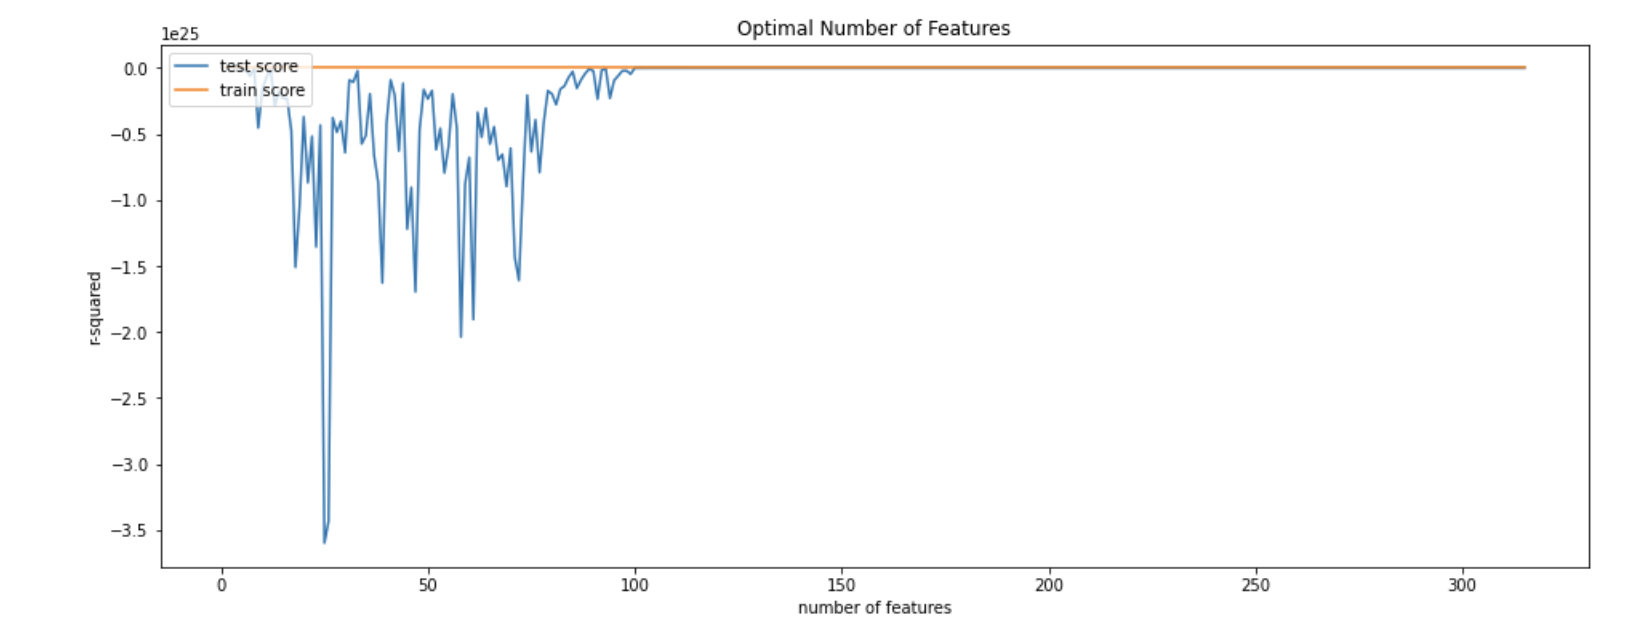

#### We have tried  to find out the optimal parameters using the GridSearchCV and K-fold and got the above graph and we can take number of parameters.

In [1415]:
n_features_optimal = 150

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

In [1416]:
#Collect all the columns whose ranks has been given by the RFE:
first_rankcol = X_train.columns[rfe.support_]
first_rankcol

Index(['LotArea', 'BsmtFinSF1', 'GrLivArea', 'MiscVal', '2ndFlrSF',
       'TotalBsmtSF', '1stFlrSF', 'PoolArea', 'garage_age_yrs', 'LowQualFinSF',
       ...
       'Exterior1st_AsphShn', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Not present',
       'GarageCond_Po', 'GarageCond_TA', 'Heating_OthW', 'Heating_Wall'],
      dtype='object', length=150)

In [1417]:
other_rankcol = X_train.columns[~rfe.support_]
other_rankcol

Index(['BsmtUnfSF', 'prop_age_mos', 'WoodDeckSF', 'GarageArea', 'HalfBath',
       'LotFrontage', 'MasVnrArea', 'remod_age_yrs', 'EnclosedPorch',
       'BsmtFinSF2',
       ...
       'Utilities_NoSeWa', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav',
       'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ',
       'BsmtFinType2_Not present', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf'],
      dtype='object', length=165)

In [1418]:
#Let's put the rank one variables which we got into the model and check the sm statstics:
X_train_rfe = X_train[first_rankcol]

# Adding a constant variable   
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train,X_train_rfe).fit()

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     107.2
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:04:38   Log-Likelihood:                -11562.
No. Observations:                1021   AIC:                         2.337e+04
Df Residuals:                     898   BIC:                         2.398e+04
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [1419]:
# Creating X_test_new dataframe by dropping variables from X_test
X_test_rfe = X_test[first_rankcol]

# Adding a constant variable 
X_test_rfe = sm.add_constant(X_test_rfe)

X_train_rfe.columns

Index(['const', 'LotArea', 'BsmtFinSF1', 'GrLivArea', 'MiscVal', '2ndFlrSF',
       'TotalBsmtSF', '1stFlrSF', 'PoolArea', 'garage_age_yrs',
       ...
       'Exterior1st_AsphShn', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Not present',
       'GarageCond_Po', 'GarageCond_TA', 'Heating_OthW', 'Heating_Wall'],
      dtype='object', length=151)

In [1420]:
# Making predictions
#y_pred = lm.predict(X_test_new)
#r2_score(y_true = y_test, y_pred = y_pred)

y_pred_train = lm.predict(X_train_rfe)
y_pred_test = lm.predict(X_test_rfe)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.935734323504821
0.7484326793939933
410059924860.3703
709095958818.8073
401625783.4087858
1618940545.2484183


Text(0.5, 0, 'Errors')

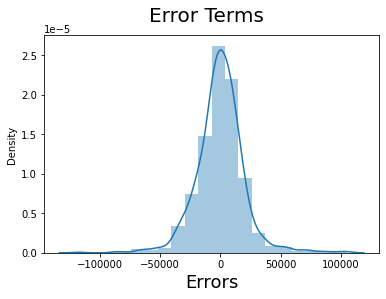

In [1421]:
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Text(0, 0.5, 'y_pred')

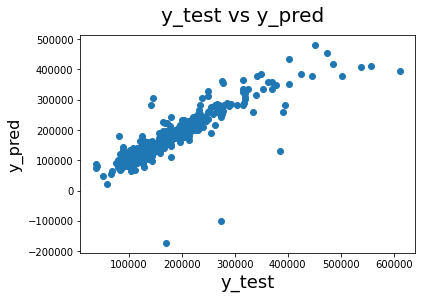

In [1422]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred_test)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

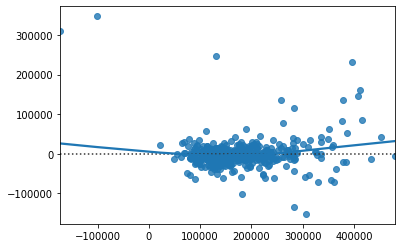

In [1423]:
#Residual plot
fig.suptitle('predicted_test vs residuals', fontsize=20) 
plt.xlabel('residuals', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label
sns.residplot(x = y_pred_test,
              y = (y_test - y_pred_test),
              data = data,
              lowess = True)
  
# show the plot
plt.show()

In [1424]:
len(X_train_rfe.columns.tolist())

151

In [1425]:
len(X_test_rfe.columns.tolist())

151

In [1426]:
X_train_rfe = X_train_rfe.drop(['const'], axis=1)
X_test_rfe = X_test_rfe.drop(['const'], axis=1)

### As we can see above we are getting good prediction on the traning data around 90% but we are getting the R^2 on test data as 72% which leaves a lot more gap between what we learnt and what we predicted. 

## Regularization: Lasso

In [1427]:
'''MSE_train=[]
MSE_test=[]
coefs = []
n_alphas = 500
alphas = np.logspace(-10, 5, n_alphas)
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    y_pred_train = lasso.predict(X_train)
    MSE_train.append(mean_squared_error(y_train,y_pred_train))

    y_pred_test = lasso.predict(X_test)
    MSE_test.append(mean_squared_error(y_test,y_pred_test))
'''

'MSE_train=[]\nMSE_test=[]\ncoefs = []\nn_alphas = 500\nalphas = np.logspace(-10, 5, n_alphas)\nfor a in alphas:\n    lasso = Lasso(alpha=a)\n    lasso.fit(X_train, y_train)\n    coefs.append(lasso.coef_)\n    y_pred_train = lasso.predict(X_train)\n    MSE_train.append(mean_squared_error(y_train,y_pred_train))\n\n    y_pred_test = lasso.predict(X_test)\n    MSE_test.append(mean_squared_error(y_test,y_pred_test))\n'

In [1428]:
# Importing the relevant libraries
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [1429]:
#Drop the lasso top predictors
#X_train_rfe = X_train_rfe.drop(['OverallQual_10','RoofMatl_WdShngl', 'TotRmsAbvGrd_12', 'PoolQC_Gd', 'Condition2_PosN'], axis = 1)
#X_test_rfe = X_test_rfe.drop(['OverallQual_10','RoofMatl_WdShngl', 'TotRmsAbvGrd_12', 'PoolQC_Gd', 'Condition2_PosN'], axis = 1)

In [1430]:
params = {'alpha': np.logspace(-2, 0.001, 100)}

# Applying Lasso
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_rfe, y_train) 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.01      , 0.0104764 , 0.0109755 , 0.01149837, 0.01204616,
       0.01262004, 0.01322126, 0.01385112, 0.01451099, 0.01520229,
       0.01592653, 0.01668527, 0.01748016, 0.01831292, 0.01918535,
       0.02009934, 0.02105688, 0.02206003, 0.02311097, 0.02421198,
       0.02536544, 0.02657385, 0.02783984, 0.02916613, 0.03055561,
       0.03201128, 0.0335363...
       0.25992526, 0.27230813, 0.28528092, 0.29887174, 0.31311002,
       0.32802662, 0.34365385, 0.36002556, 0.37717722, 0.39514599,
       0.41397079, 0.43369241, 0.45435356, 0.47599902, 0.49867567,
       0.52243264, 0.54732139, 0.57339585, 0.6007125 , 0.62933051,
       0.65931189, 0.69072159, 0.72362765, 0.75810135, 0.79421739,
       0.832054  , 0.87169316, 0.91322072, 0.95672667, 1.00230524])},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [1431]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 1.0023052380778996}


In [1432]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha = model_cv.best_params_.get('alpha')

print(alpha)

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_rfe, y_train) 

1.0023052380778996


Lasso(alpha=1.0023052380778996)

In [1433]:
lasso.coef_

array([ 1.32977045e+04,  2.03919044e+04,  4.46610598e+04,  0.00000000e+00,
        1.83548605e+04,  3.09983250e+04,  1.66730850e+04,  0.00000000e+00,
       -1.76704842e+04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.66714032e+04, -6.34219470e+04, -8.60185817e+03, -5.67617628e+03,
        2.35251856e+04, -6.13845014e+03, -2.74322659e+04,  4.00545579e+04,
        2.19806346e+04,  2.45068086e+04,  2.06716883e+04,  2.21522013e+04,
        3.91784420e+04,  3.01755065e+04, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -3.16442281e+02, -3.65635977e+03, -1.41997747e+02,
       -1.63435893e+03,  8.93853904e+02,  9.11033286e+02,  2.74747566e+04,
       -6.81510293e+03,  4.84859832e+04,  2.69301647e+04,  1.53574574e+03,
        1.11807495e+04,  1.25710114e+04, -2.27734884e+03, -5.04741227e+02,
        1.42885022e+04,  2.36520659e+04, -1.34138178e+04, -1.32565324e+04,
       -9.46548753e+03, -1.05990087e+04, -9.50280459e+03,  7.09103148e+02,
        2.17693220e+04,  

In [1434]:
lasso.get_params()

{'alpha': 1.0023052380778996,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [1435]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train_rfe)
y_pred_test = lasso.predict(X_test_rfe)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.935718724993098
0.721187425261186
410159454265.3945
785892498035.5302
401723265.6859887
1794275109.67016


Text(0.5, 0, 'Errors')

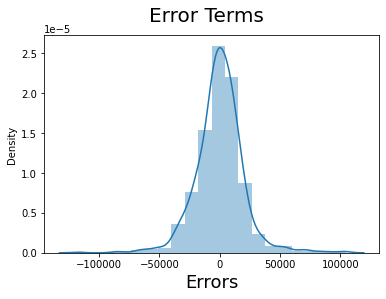

In [1436]:
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Text(0, 0.5, 'y_pred')

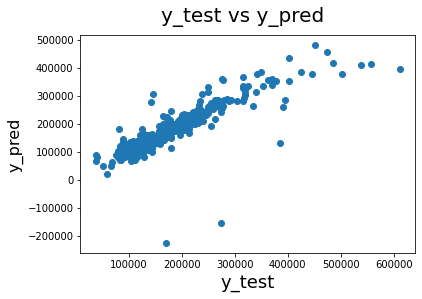

In [1437]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred_test)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

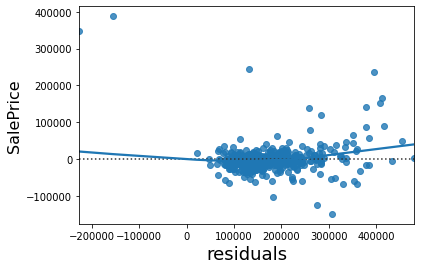

In [1438]:
#Residual plot
fig.suptitle('predicted_test vs residuals', fontsize=20) 
plt.xlabel('residuals', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label
sns.residplot(x = y_pred_test,
              y = (y_test - y_pred_test),
              data = data,
              lowess = True)
  
# show the plot
plt.show()

### Ridge 

In [1439]:
'''
X_train_rfe= X_train_rfe.iloc[:,lasso.coef_!=0]
X_test_rfe= X_test_rfe.iloc[:,lasso.coef_!=0]
'''

#We could have used the filtered columns from Lasso but then again we can do ridge on the same data and check

'\nX_train_rfe= X_train_rfe.iloc[:,lasso.coef_!=0]\nX_test_rfe= X_test_rfe.iloc[:,lasso.coef_!=0]\n'

In [1440]:
params = {'alpha': np.logspace(-2, 0.001, 100)}

# Applying Lasso
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([0.01      , 0.0104764 , 0.0109755 , 0.01149837, 0.01204616,
       0.01262004, 0.01322126, 0.01385112, 0.01451099, 0.01520229,
       0.01592653, 0.01668527, 0.01748016, 0.01831292, 0.01918535,
       0.02009934, 0.02105688, 0.02206003, 0.02311097, 0.02421198,
       0.02536544, 0.02657385, 0.02783984, 0.02916613, 0.03055561,
       0.03201128, 0.0335363...
       0.25992526, 0.27230813, 0.28528092, 0.29887174, 0.31311002,
       0.32802662, 0.34365385, 0.36002556, 0.37717722, 0.39514599,
       0.41397079, 0.43369241, 0.45435356, 0.47599902, 0.49867567,
       0.52243264, 0.54732139, 0.57339585, 0.6007125 , 0.62933051,
       0.65931189, 0.69072159, 0.72362765, 0.75810135, 0.79421739,
       0.832054  , 0.87169316, 0.91322072, 0.95672667, 1.00230524])},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [1441]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.5473213937810939}


In [1442]:
alpha = model_cv.best_params_.get('alpha')
print(alpha)
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_rfe, y_train)
print(ridge.coef_)

0.5473213937810939
[  14400.96259315   20804.10220618   43081.21372253       0.
   18196.03716786   31535.53231234   16160.70676552       0.
  -13652.34578048       0.               0.               0.
   -5450.73125344  -30853.22210539   -4630.44635006   -3345.41446815
   10900.00341995   -8263.55678832  -17241.77167273   45065.80962804
   12688.09481572   15684.55575534   11261.39874216   15218.13240778
   21447.23602444   12140.52380661  -13450.69239984    1310.16859321
   -3310.31148728   -4857.61372207   -7000.17318419   -3632.45188528
   -4988.47549291   -3098.49919288   -3227.57254454   22009.59408572
  -23692.0299619    10350.29736087   21447.23602444     961.21244399
   13753.68776282  -13786.362527    -12539.15385664   -9490.36883918
    7246.41166858   18088.58014402  -23188.61571878  -20149.54961074
  -18259.86773008  -18390.66692699  -17147.62528123   -6623.04281109
   12557.8596477    37740.56630287   82293.59234946    4219.97511366
  -25319.09597879   -6525.9756354    -3

In [1443]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train_rfe)
y_pred_test = ridge.predict(X_test_rfe)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9271426300349342
0.8338757057166319
464880933069.15155
468256629892.13367
455319229.25480074
1069079063.6806705


Text(0.5, 0, 'Errors')

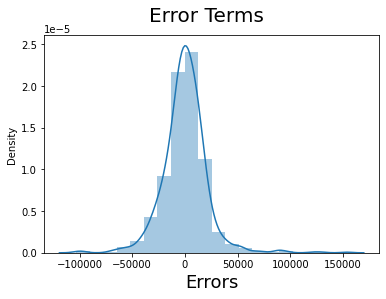

In [1444]:
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Text(0, 0.5, 'y_pred')

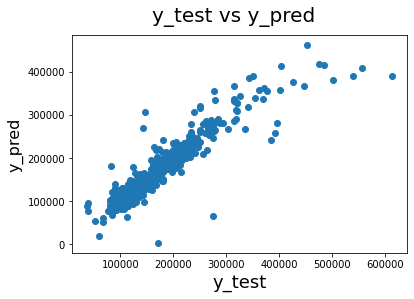

In [1445]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred_test)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

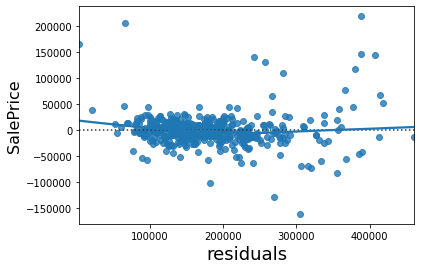

In [1446]:
#Residual plot
fig.suptitle('predicted_test vs residuals', fontsize=20) 
plt.xlabel('residuals', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label
sns.residplot(x = y_pred_test,
              y = (y_test - y_pred_test),
              data = data,
              lowess = True)
  
# show the plot
plt.show()

In [1448]:
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.357343e-01,9.271426e-01,9.357187e-01
1,R2 Score (Test),7.484327e-01,8.338757e-01,7.211874e-01
2,RSS (Train),4.100599e+11,4.648809e+11,4.101595e+11
3,RSS (Test),7.090960e+11,4.682566e+11,7.858925e+11
4,MSE (Train),2.004060e+04,2.133821e+04,2.004304e+04
5,MSE (Test),4.023606e+04,3.269677e+04,4.235888e+04


### Ridge regression gave us the best output of standardisation. Lasso Standardisation did reduce the R2 score of train a bit but could not help us so much in R2 score or other metrics on test

In [1449]:
betas = pd.DataFrame(index=X_train_rfe.columns)

In [1450]:
betas.rows = X_train_rfe.columns

In [1451]:
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)

#Top 5 variables with positive coefficients 
print(betas.sort_values(by=['Ridge'], ascending=False).head())
#Top 5 variables with negative coefficients 
print(betas.sort_values(by=['Ridge'], ascending=True).head())

                             Ridge          Lasso
RoofMatl_WdShngl      84794.635768   77288.919986
OverallQual_10        82293.592349  112845.866055
Neighborhood_NoRidge  50952.182357   47292.339759
FullBath_3            45065.809628   40054.557886
GrLivArea             43081.213723   44661.059760
                            Ridge          Lasso
PoolQC_Gd          -188351.889525 -499887.605520
Condition2_PosN    -178410.067029 -314533.234742
PoolQC_Not present  -49086.392892 -130050.838092
Heating_OthW        -34719.500130  -55821.621266
MSSubClass_75       -30853.222105  -63421.946976


#### So from the above we have sorted out that out 315 parameters which includes dummy encoding parameters too, a range of optimal parameters above 100-150 which we can confirm with our grid search CV gives us all sorts of output, but using ridge regression & lasso we involve Standardisation and we have compared the metrics:

   * The 5 most positive coefficients which we got are:
       * Roof made with wood shingles.
       * Overall material and finish of the house comes to be best rated: 10.
       * Neighborhood is Northridge.
       * Full bathrooms above grade 3.
       * Above grade (ground) living area square feet.
    
   * The 5 factors which negatively affect the sale price:
       * Pool quality is just good.
       * Condition 2: Proximity to various conditions: Near positive off-site feature--park, greenbelt, etc.
       * No pool.
       * Hot water or steam heat other than gas
       * dwelling involved in the sale: 2-1/2 STORY ALL AGES

In [1452]:
#Top 5 variables with positive coefficients 
print(betas.sort_values(by=['Lasso'], ascending=False).head())
#Top 5 variables with negative coefficients 
print(betas.sort_values(by=['Lasso'], ascending=True).head())

                             Ridge          Lasso
OverallQual_10        82293.592349  112845.866055
RoofMatl_WdShngl      84794.635768   77288.919986
TotRmsAbvGrd_12       10350.297361   48485.983163
HouseStyle_2.5Unf     12335.570785   47366.016619
Neighborhood_NoRidge  50952.182357   47292.339759
                            Ridge          Lasso
PoolQC_Gd          -188351.889525 -499887.605520
Condition2_PosN    -178410.067029 -314533.234742
PoolQC_Not present  -49086.392892 -130050.838092
PoolQC_Fa           -14035.739970 -101044.650389
Condition2_RRAe     -13580.413319  -72478.895096


### As per lasso the above is the analysis predictors, if we cut the common in between lasso and ridge, the impactful contributors/predictors will be:

* Overall material and finish of the house comes to be best rated: 10.
* Roof made with wood shingles.
* Neighborhood is Northridge.

#### As for the negatively impacted ones:
* Pool quality is just good and infact if there is no pool, it gets the price down.
* Proximity to various conditions: Near positive off-site feature--park, greenbelt, etc.

>>Those might be the overall huge impact makers